# 7333 - Quantifying the World
# Unit 8 Case Study
# Authors: Brandon De La Houssaye, Bruce Granger, Daniel Serna

Required Packages

In [28]:
from pandas import datetime
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline

import pandas_profiling
import pandas as pd
from pathlib import Path
import numpy as np
from numpy.polynomial.polynomial import polyfit
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

BASIC INTRO

We have pulled four years of data for Walmart (WMT).  Walmart is a publicly traded company incorporated within the United States.

The company is a retailer with retail operations in well over 35 countries throughout the world from retail and services standpoint.  The company is also globally active in its supply chain footprint and directly or indirectly responsible for 
vast quantities of imports/exports in a number of countries.

Walmart is a fortune 1 company and the largest private employer in the world that operates in all 50 states.

The comnpany first went public on Oct 1, 1970 with a price of $16.50 per share.  

The company is often regarded as a bellweather of US financial health and growth amongst other things. For example, the 'Walmart effect' can refer to patterns utilized by the CDC for tracking flu outbreaks as well as macro consumer habits.

However, Walmart's stock price is clearly not singularly impacted by the company's performance or the US economy overall.  Factors such as investor sentiment and competitor impacts may have a severe impact on pricing.  As a result, it is useful to consider Walmart's stock price change over time in the context of whether it is stationary, cyclical, random, etc.  

To begin, we will consider 10 years of financial data in order to fully assess the stock market price since the last major recession; the rapid rise of key competitors (e.g., Amazon); and other PR related impacts.

## Injest Data

In [38]:
config = Path('./wmt.csv')

if config.is_file():
    wmt_temp = pd.read_csv("wmt.csv")
    wmt_temp.rename(columns={'date': 'Day'}, inplace=True)
    wmt_stock = wmt_temp['close']
    wmt_stock.index=pd.to_datetime(wmt_temp['Day'])
    print("Data was found locally and imported.")
else:
    # import yahoo_fin
    # import requests_html
    from yahoo_fin import stock_info as si
    Start_Date = '10/15/2016'; End_Date = '10/15/2019'
    wmt_temp = si.get_data("wmt", start_date = Start_Date, end_date = End_Date)
    wmt_temp.rename(columns={'date': 'Day'}, inplace=True)
    
    wmt_stock = wmt_temp['close']
    wmt_stock.reset_index(inplace=True)
    wmt_stock.index=pd.to_datetime(wmt_temp['Day'])
    wmt_data.to_csv("wmt.csv", index=False)
    print("Data was not found locally; data was downloaded and preserved as a CSV.")

Data was found locally and imported.


In [53]:
#Walmart Profile


profile = pandas_profiling.ProfileReport(wmt_temp)
profile

Number of variables,8
Number of observations,1006
Total Missing (%),0.0%
Total size in memory,63.0 KiB
Average record size in memory,64.1 B
Numeric,2
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,5


Day
2015-10-15    59.330002
2015-10-16    58.889999
2015-10-19    58.849998
2015-10-20    58.750000
2015-10-21    58.639999
Name: close, dtype: float64


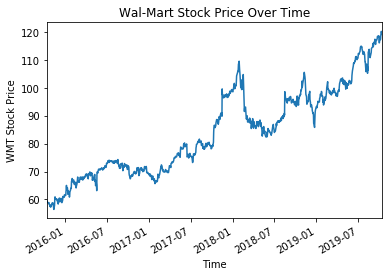

In [41]:
print(wmt_stock.head())
fig = plt.figure()
wmt_stock.plot()
plt.title("Wal-Mart Stock Price Over Time")
plt.xlabel("Time")
plt.ylabel('WMT Stock Price')
plt.show()

In [ ]:
On a first view, the data does not appear to be cyclical. 

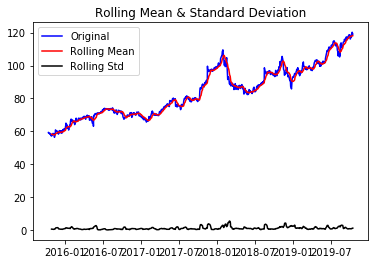

Results of Dickey-Fuller Test:
Test Statistic                   -0.419603
p-value                           0.906774
#Lags Used                        1.000000
Number of Observations Used    1004.000000
Critical Value (1%)              -3.436880
Critical Value (5%)              -2.864423
Critical Value (10%)             -2.568305
dtype: float64


In [43]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    global dftest 
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

test_stationarity(wmt_stock)

In [44]:
def test_stat_vs_crit_val():
    
    for key,value in dftest[4].items():
        if dftest[0] > value:
            print("The Test Statistic of", dftest[0], "is greater than the Critical Value", key, "value of", value)
        elif dftest[0] < value:
            print("The Test Statistic of", dftest[0], "is less than theCritical Value", key, "value of", value)

In [46]:
test_stat_vs_crit_val()

The Test Statistic of -0.41960301097381164 is greater than the Critical Value 1% value of -3.436879978012783
The Test Statistic of -0.41960301097381164 is greater than the Critical Value 5% value of -2.86442302475405
The Test Statistic of -0.41960301097381164 is greater than the Critical Value 10% value of -2.568305057578451


The above information shows us something very basic.  The Walmart data is not stationary.  There is an upward trend.  There is clearly some cyclicality, or randomness in the data.  the rolling mean information overlays quite well with the actual mean information (showing patterns as opposed to extreme outliers) of trend.  While the std deviation results appear flat, there are some jumps (it is not perfectly smooth which would indicate that the results carry some randomness).  So the data isn't stationary or purely seasonal.  We will continue pushing it to make it stationary, starting with log transformation which mutes the variances between observations.  

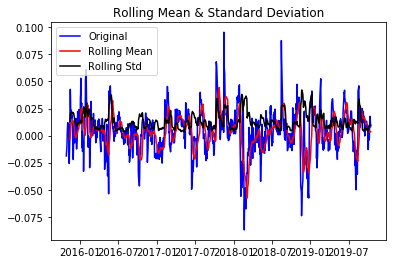

Results of Dickey-Fuller Test:
Test Statistic                -9.530086e+00
p-value                        2.906529e-16
#Lags Used                     0.000000e+00
Number of Observations Used    9.940000e+02
Critical Value (1%)           -3.436946e+00
Critical Value (5%)           -2.864452e+00
Critical Value (10%)          -2.568321e+00
dtype: float64


In [47]:
log_wmt_stock = np.log(wmt_stock)
log_moving_avg = log_wmt_stock.rolling(12).mean()
log_no_trend = log_wmt_stock - log_moving_avg
test_stationarity(log_no_trend.dropna())

In [48]:
test_stat_vs_crit_val()

The Test Statistic of -9.530086068900157 is less than theCritical Value 1% value of -3.43694584277544
The Test Statistic of -9.530086068900157 is less than theCritical Value 5% value of -2.8644520725172873
The Test Statistic of -9.530086068900157 is less than theCritical Value 10% value of -2.5683205291305176


So the log transformation helped.  It tampered back the variance results observed and made the visualizations easier to read. 

What comes out is still clear evidence of non-stationary data.  It is clear that to analyze this time series data next steps of cleanse/analysis is needed.  For additional reference, provided below is the trend, seasonal, and residual plots of the log transformed data.  Again, very clear evidence of non-stationary data.

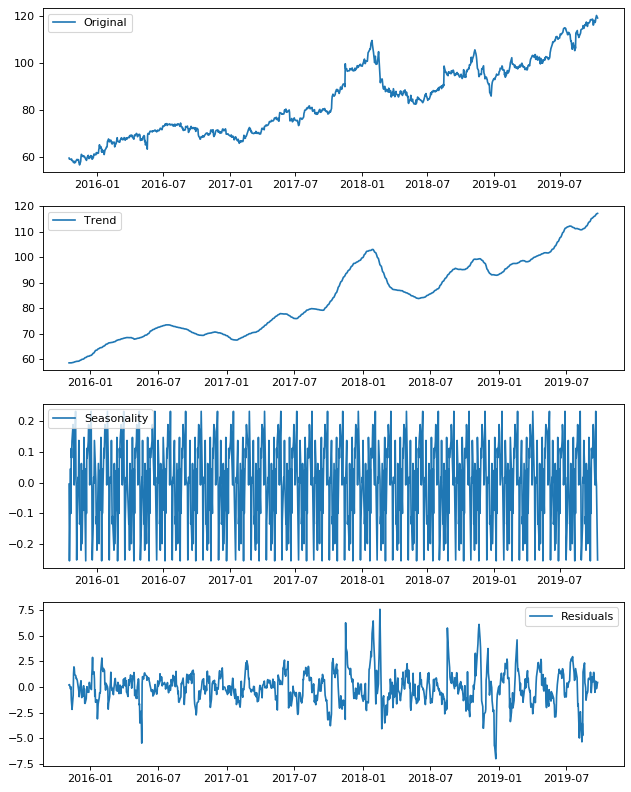

In [49]:
# from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(wmt_stock, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(num=None, figsize=(8, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(411)
plt.plot(wmt_stock, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

As a next step, we will begin by looking at autocorrelationa and partial autocorrelation plots. These plots are provided below.  

Autocorrelation is a form of statistical correlation (i.e., the measured strength in relationship between two variables) for time series data (which is what we are managing here).  In effect, for the autocorrelation function, we are trying to measure the statistical relationship for time series data against time series data from a previous time step (or periods); which are called 'lags'.  That is, the time series of data is correlated over (and over, depending on defined 'lags') against the same series data from a previous period(s).  

Whereas, with partial autocorrelation, we get a summary of the relationship between time series sets from different times steps - same as for autocorrelation - but without observations at intervening (or non-compared) time steps.  In other words, partial autocorrelation attemps to get a more complete picture of the entire population of time series data.

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Autocorrelation Function')

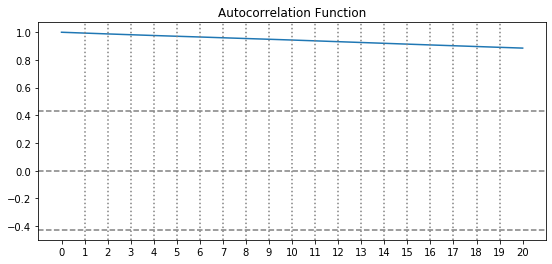

In [50]:
#from statsmodels.tsa.stattools import acf, pacf
acf_wmt_plot = acf(wmt_stock.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(acf_wmt_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_wmt_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_wmt_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Autocorrelation Function')

Text(0.5, 1.0, 'Partial Autocorrelation Function')

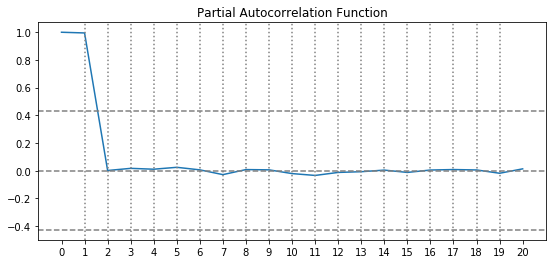

In [52]:
pacf_wmt_plot = pacf(wmt_stock.dropna(), nlags=20)
#Plot ACF: 
plt.figure(figsize=(20, 4))

plt.subplot(121) 
plt.plot(pacf_wmt_plot)
plt.xticks(np.arange(21))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(acf_wmt_plot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(acf_wmt_plot)),linestyle='--',color='gray')
for i in range(1,20):
    plt.axvline(x=i,linestyle=':',color='gray')
plt.title('Partial Autocorrelation Function')

What does this information tell us?  First, it tells us that we definitely have non-stationary data.  Second, it tells us that to further our analysis we are going to have to start incorporating differences (as well as, maybe, moving averages).

What follows next is an exploration of ARIMA with particular focus on hypertuning p,d,q parameters.  We will wrap up the ARIMAS exploration with a grid search of those same paramters in order to arrive at the best possible combination (as measured by Loss).  We will also explore the metric of AIC - a basic accuracy score - in order to consider the parameter sets for the ARIMAS model.  Ultimately, this all leads to the ability to decipher the past time events in order to understand/predict future events given time events that have occured in a pattern over time that is not readily explainable outside of other, unprovided for variables.   

## Question 1 - Intuition

In [56]:
def runArima(dataset, p, d, q, showRSS=False):  
    model = ARIMA(dataset.dropna(), order=(p, d, q))  
    try:
        results_ARIMA = model.fit(disp=-1)
    except ValueError:
        pass
    except:
        pass
    
    if(showRSS):
        plt.plot(dataset)
        plt.plot(results_ARIMA.fittedvalues, color='red')
        x=pd.DataFrame(results_ARIMA.fittedvalues)
        x=x.join(wmt_stock)
        x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
        loss=np.sqrt(x['out'].sum())
        plt.title('RSS: %.4f'% loss)
    
    #from statsmodels.tsa.stattools import acf, pacf
    acf_wmt_plot = acf(results_ARIMA.fittedvalues, nlags=20)
    #Plot ACF: 
    plt.figure(figsize=(20, 4))

    plt.subplot(121) 
    plt.plot(acf_wmt_plot)
    plt.xticks(np.arange(21))
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(acf_wmt_plot)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(acf_wmt_plot)),linestyle='--',color='gray')
    for i in range(1,20):
        plt.axvline(x=i,linestyle=':',color='gray')
    plt.title('Autocorrelation Function')
    print(f"p:{p} d:{d} q:{q}")

### We will first analyze results by adjusting the d parameter.

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


p:0 d:0 q:0


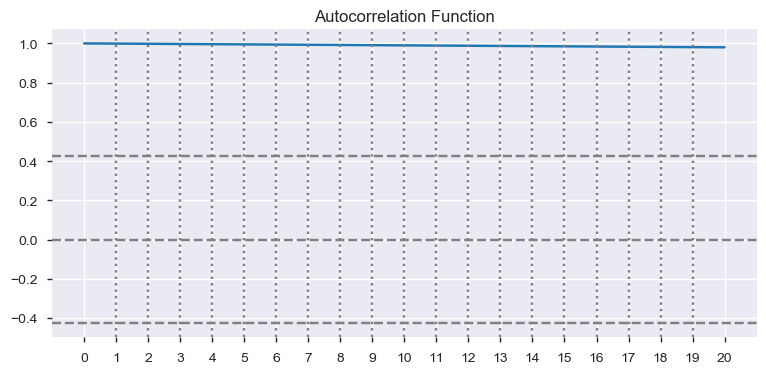

In [71]:
p = 0
d = 0
q = 0
runArima(wmt_stock.dropna(),p,d,q)

Leveraging Rule #1, we observe that this series has a positive correlations out to a high number of lags.  For that reason, we will immediately re-run the model with 1 higher level of differencing.  

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


p:0 d:1 q:0


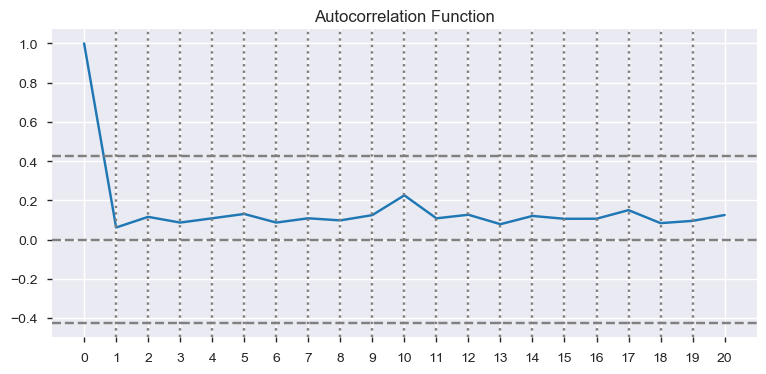

In [59]:
d = 1
runArima(wmt_stock.dropna(),p,d,q)

Leveraing rule #2, the lag-1 autocorrelation is not zero or negative, but the autocorrelations are all small and there doesn't seem to be much in the way of a discernable pattern.  For purposes of really exploring this data, we will see what happens when a differencing of -2 is provided. We are doing this especially because we cannot see evidence of overdifferening after lag-1 

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


p:0 d:2 q:0


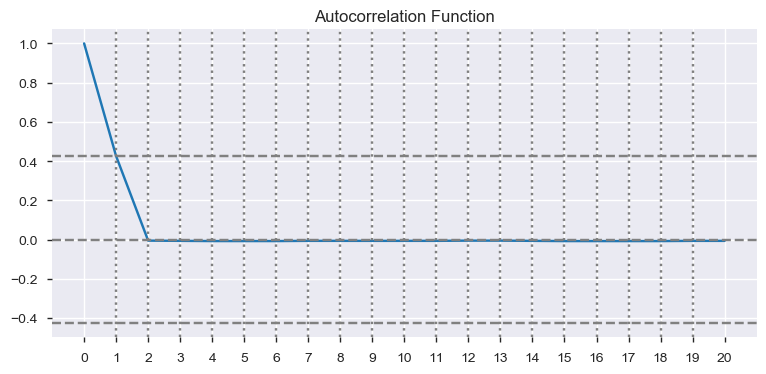

In [60]:
d = 2
runArima(wmt_stock.dropna(),p,d,q)

Ok, these results are interesting.  After lag-2, the autocorrelation seems to arrive at '0'.  This would indicate that any additional differencing would severely run the risk of overdifferencing.  We will keep the d level at 2 and move onto the remaining rules.

As for the other rules not yet covered (for parameter d), in using two orders of differencing (thus far) it is apparent that the original series has a time varying trend (Rule #4).  Simply put, the model does not seem to stationary or constant in trend.  Rules 5 and Rules 3 do not necessarily apply:  this model has at least 1 order of differencing so it does not require a constant.  With respect to Rule 3, we will see how the potential of std results may fair with MA terms.

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


p:0 d:0 q:2


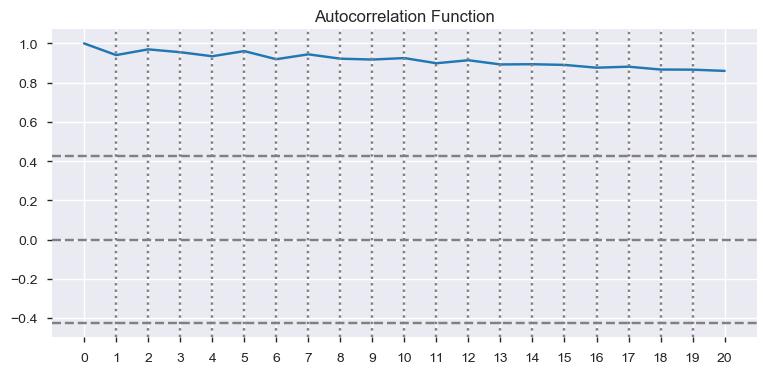

In [75]:
q = 2
runArima(wmt_stock.dropna(),p,d,q)

These results clearly show...we have regressed in our intentions for the ARIMA model.  The moving average inclusion clearly does not help us in building a time series model for this data.  The q results should remain alone with no moving average parameter inclusion. On an overall basis, the results are not that surprising.  The moving average essentially shows that there is some pattern to the time series data.  However, the pattern does not - when considering the impacts of moving averages - enable us to understand the present (or future) when observing the past as is.   

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


p:2 d:0 q:0


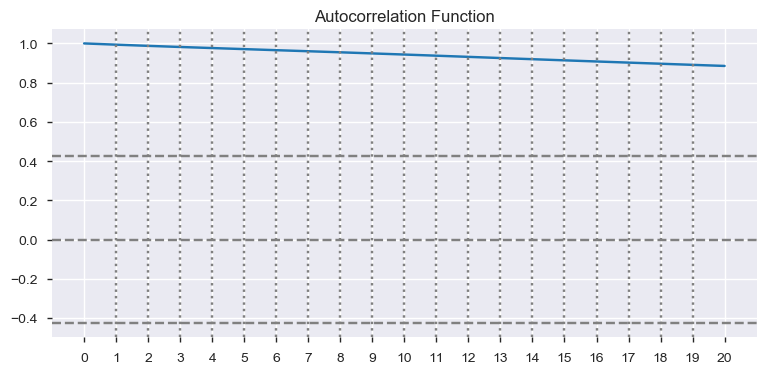

In [86]:
p = 2
d = 0
q = 0
runArima(wmt_stock.dropna(),p,d,q)

This is interesting...and it isn't interesting.  The autocorrelation has the same pattern at the autocorrelation function.  Whether the autocorrelation parameter is 1 and 2.  We can infer from this that there is consistency in applied models.  We can also infer - understandably - that whether the parameter is 1 or 2 the autocorrelation is occuring between the current time series observations and prior time series observations.  Thus, the primary parameter of consideration really is d (differences).  

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


p:2 d:2 q:0


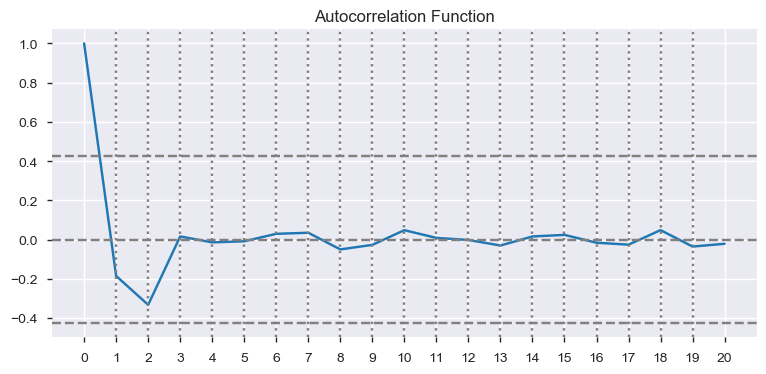

In [87]:
p = 2
d = 2
q = 0
runArima(wmt_stock.dropna(),p,d,q)

Of course, comblining the autocorrelation with the differences creates a problem.  A problem that violates rule #7.  The series is now overdifferenced.  This is true whether p is 1 or 2.  

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


p:2 d:2 q:2


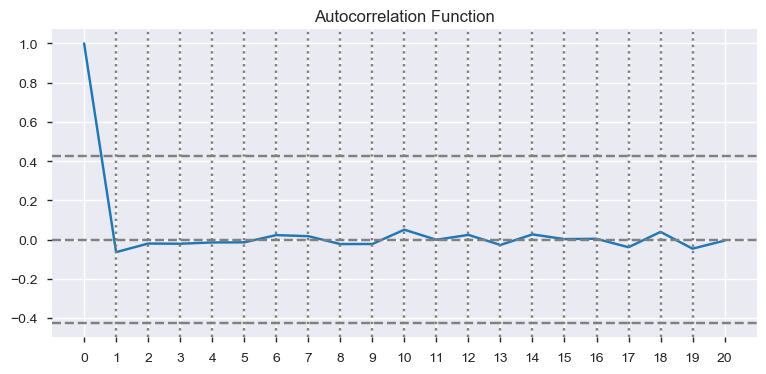

In [91]:
p = 2
d = 2
q = 2
runArima(wmt_stock.dropna(),p,d,q)

Here we set AR and MA terms to equal each other.  What is interesting is that, given prior variations of the model run, it is clear the terms cancel each other out.  That is, it wouldn't matter if they were set to "2" or "1" in this case in terms of the overall model correlation.  As a result, we will revert both parameters back to 0.

After going through various iterations of the ARIMA model parameters p,d,q, it is visually apparent that the most appropriate settings are 0,2,0. 

In order to assess this conclusion, we will not perform a 'brute force' analysis using Loss scores (while also pulling AIC scores).  Finally, for consideration of Rule #3, we have also pulled in std deviation scores.

    BRUTE FORCE

Now I am just going to do a brute force search for parameters and find the best  ones.

495.6810484363552


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


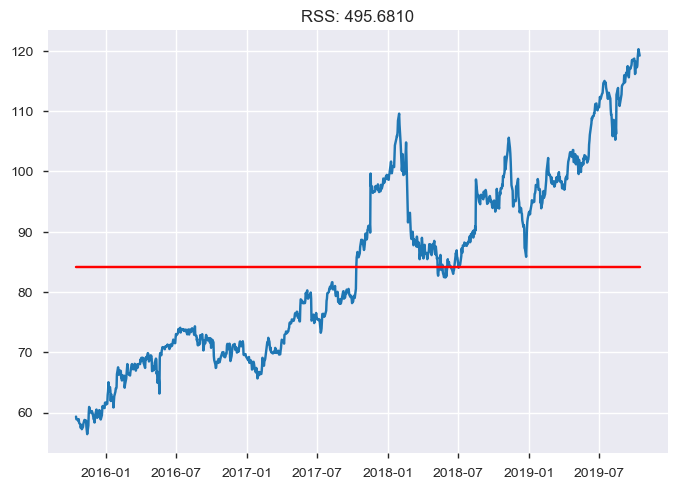

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0 0 0
262.5911778094207


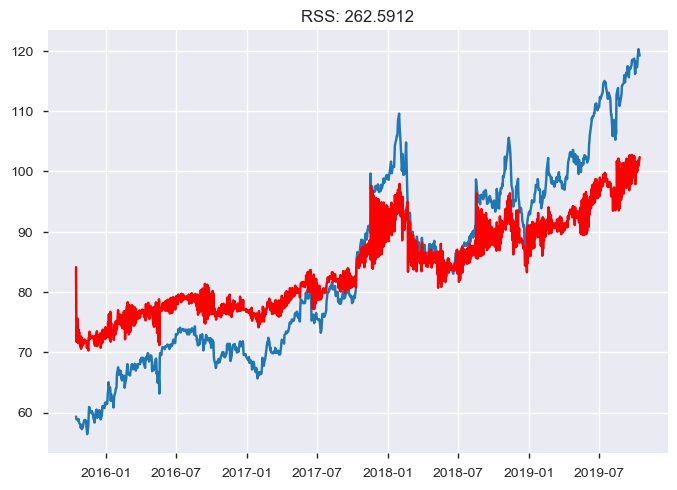

0 0 1
161.3891345458814


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


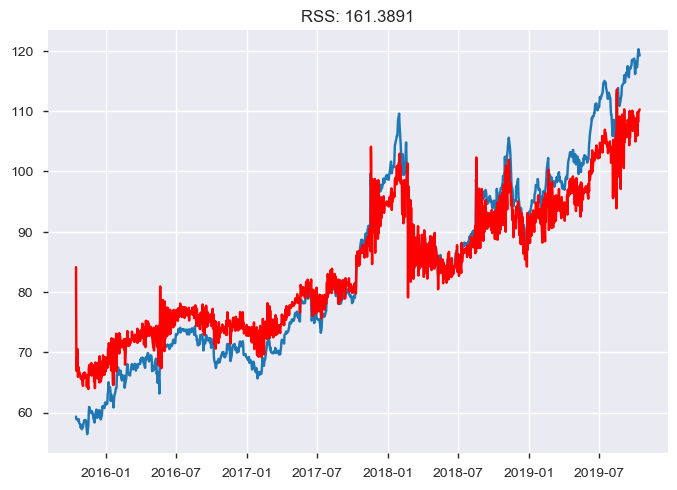

0 0 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


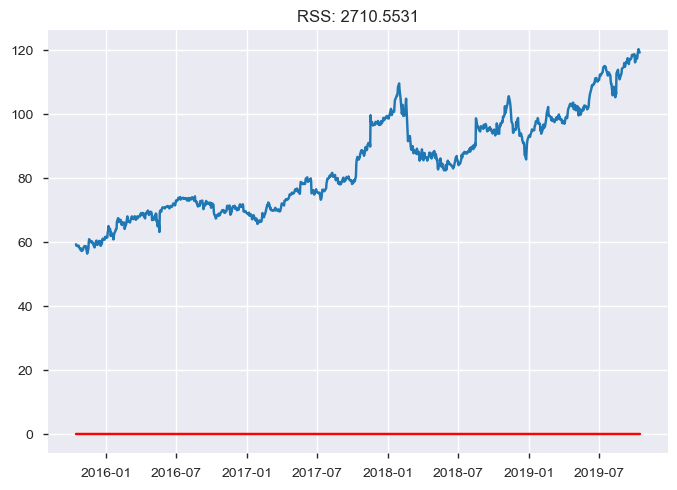

0 1 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


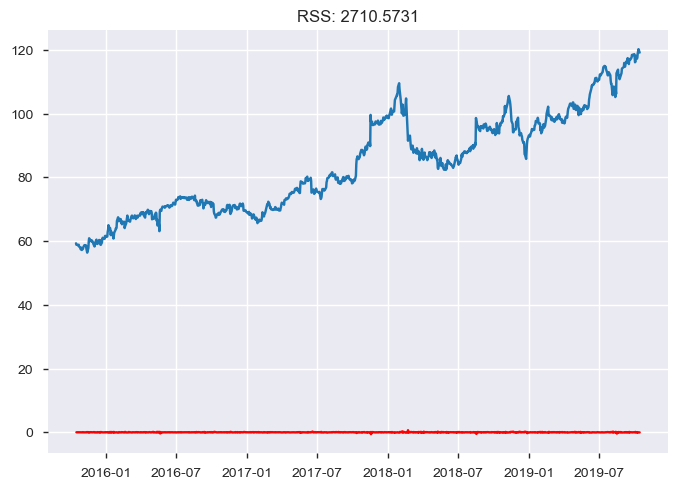

0 1 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


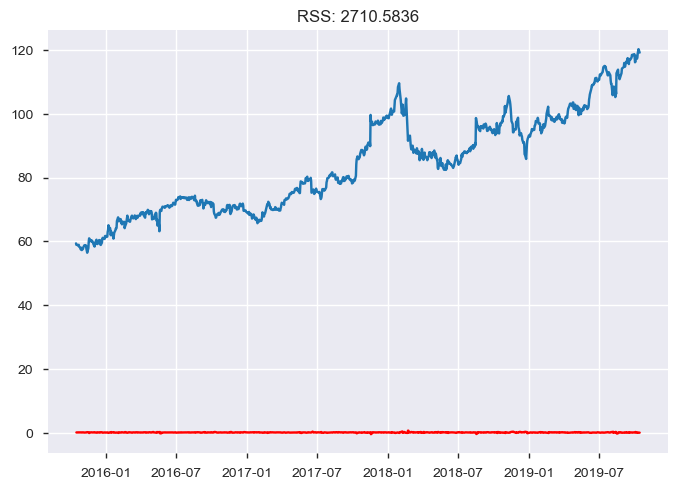

0 1 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


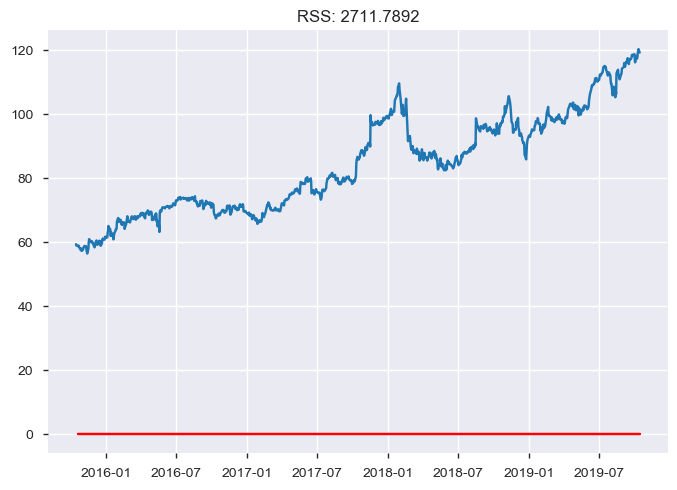

0 2 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


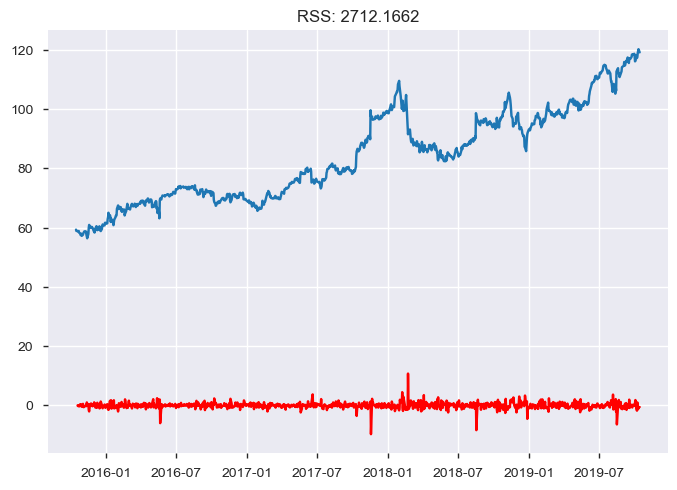

0 2 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


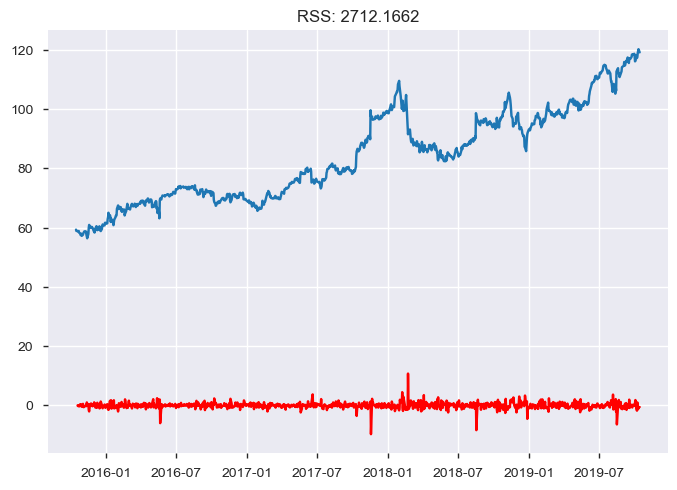

0 2 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


43.997115746183596


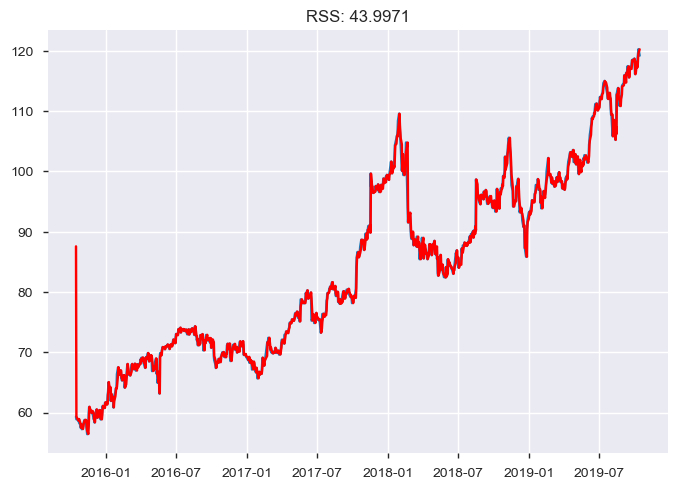

1 0 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


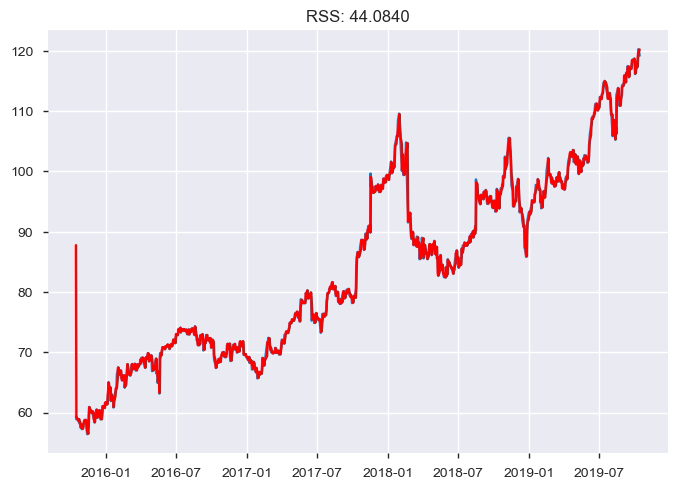

1 0 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


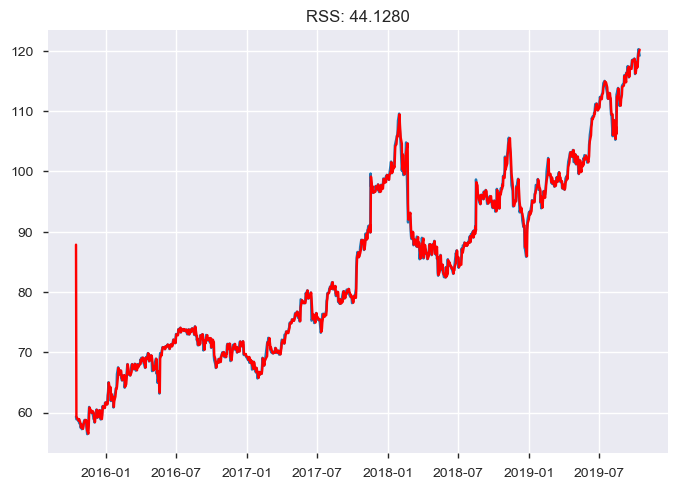

1 0 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


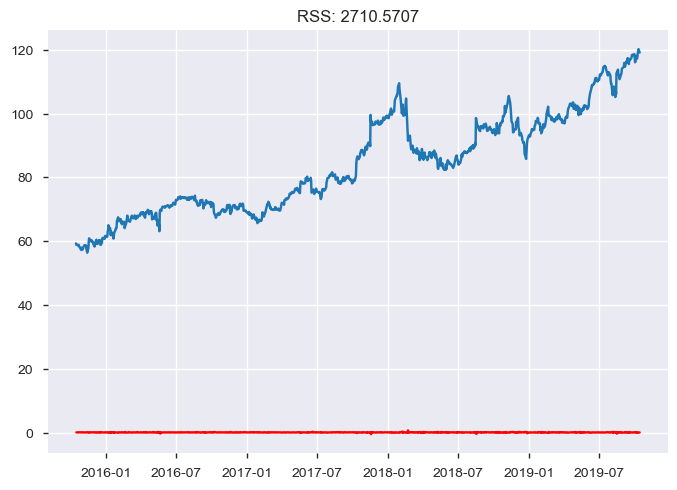

1 1 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


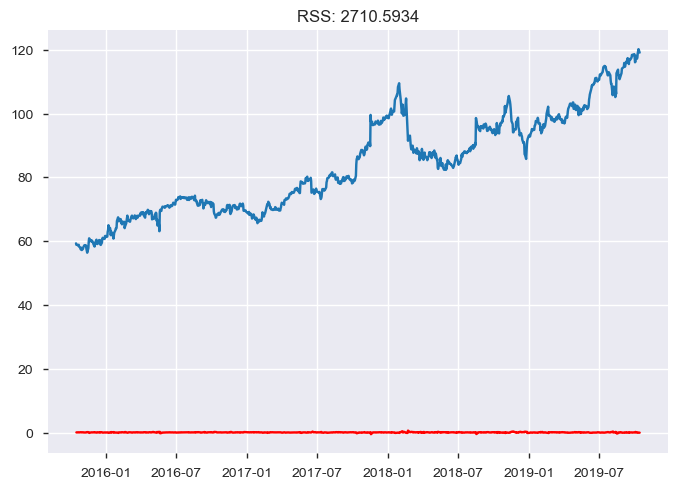

1 1 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


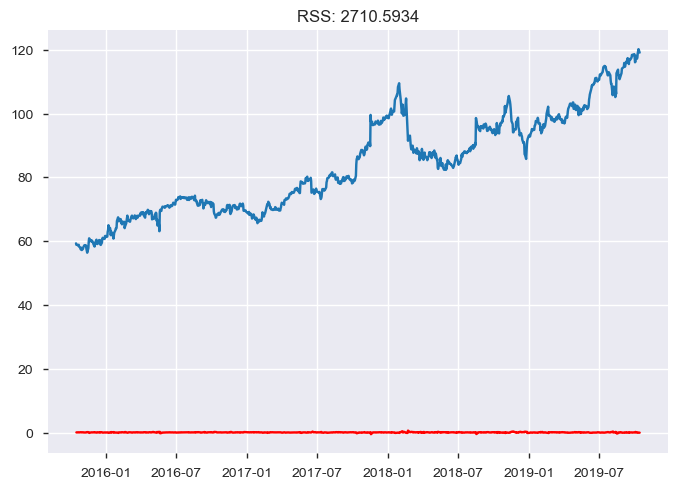

1 1 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


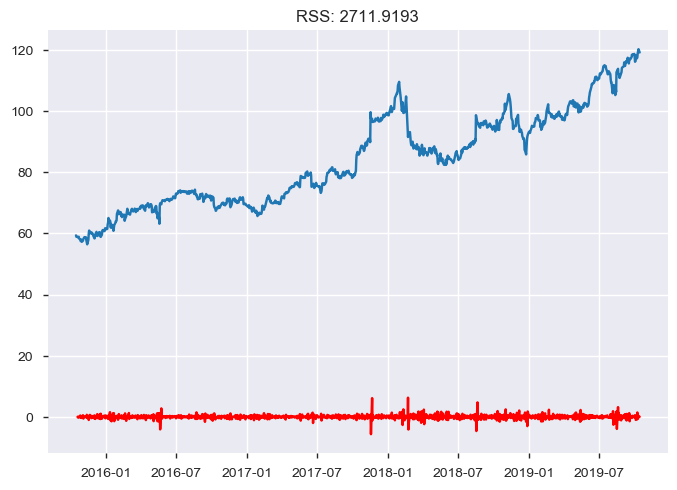

1 2 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


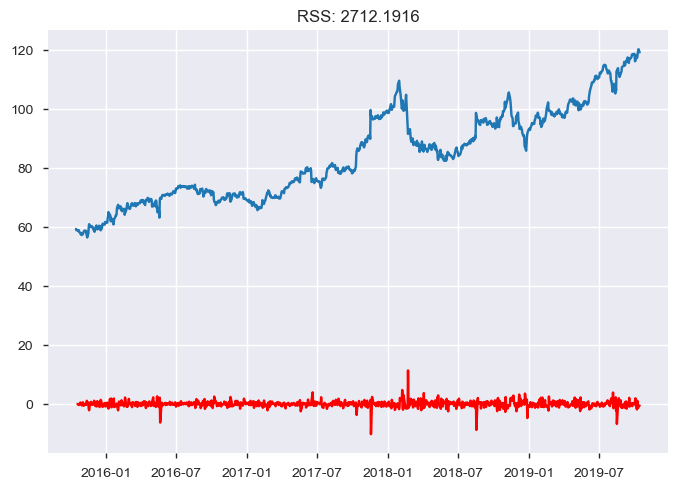

1 2 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


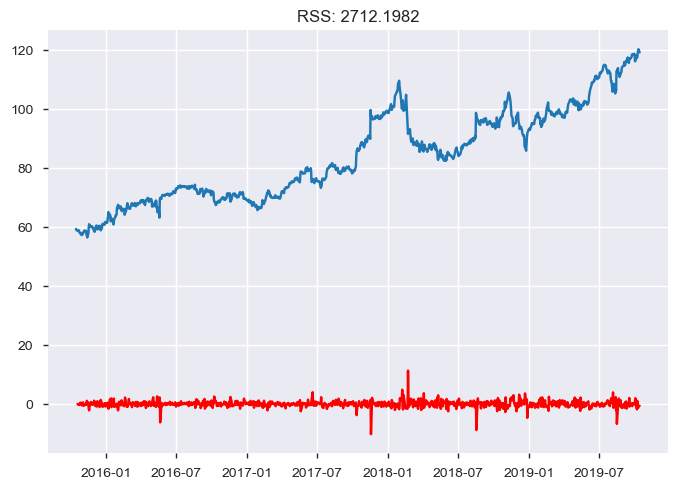

1 2 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


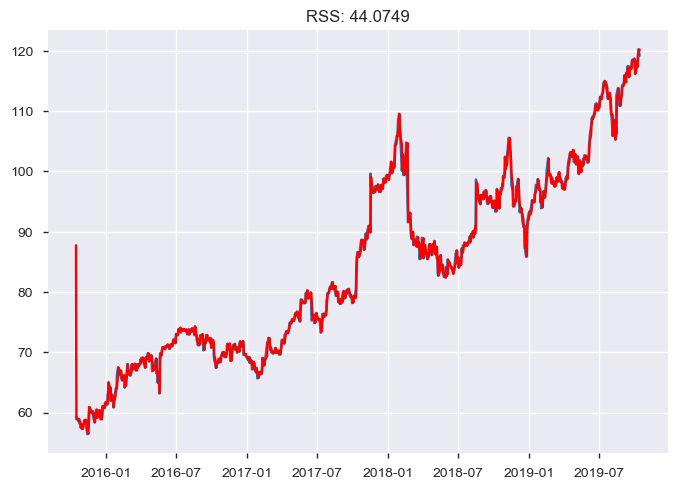

2 0 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


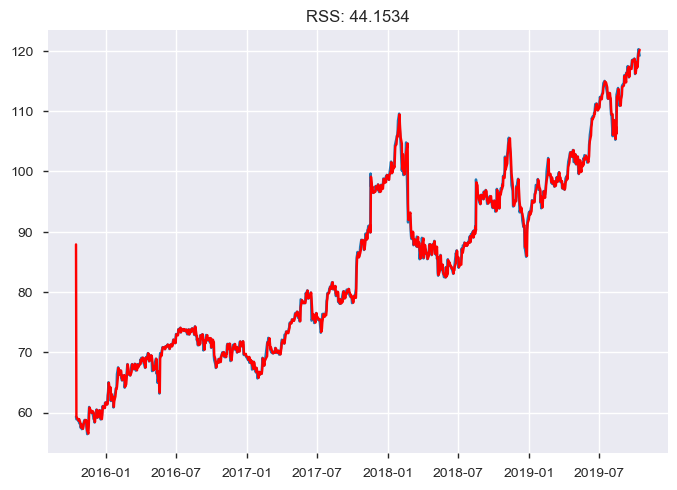

2 0 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


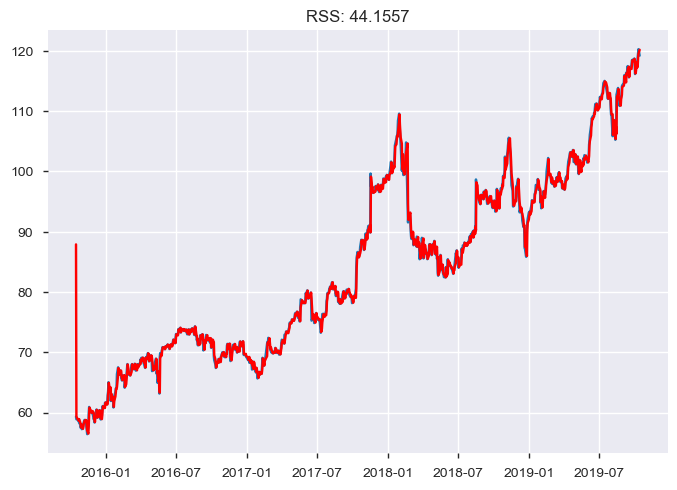

2 0 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


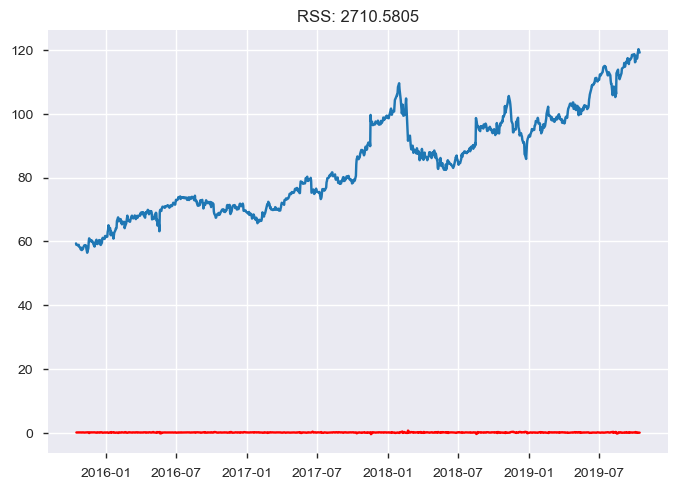

2 1 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


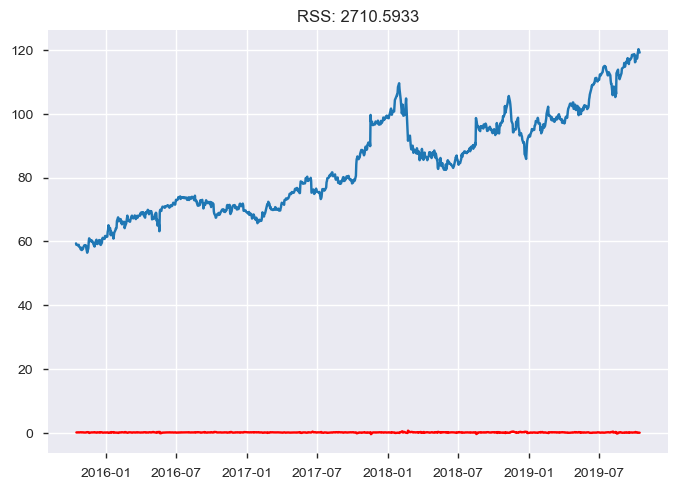

2 1 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


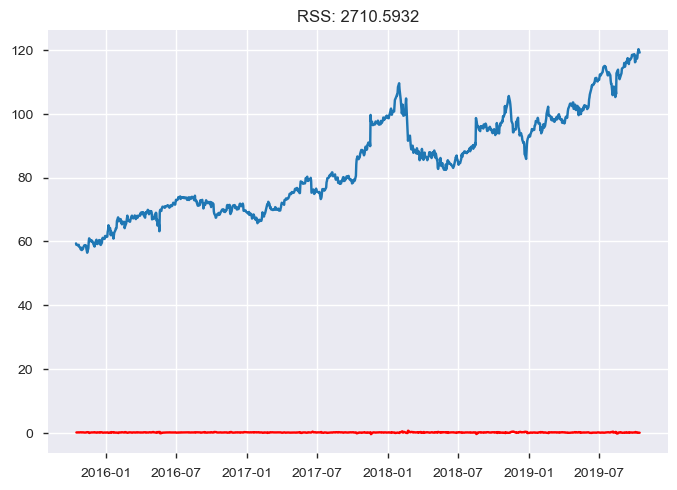

2 1 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


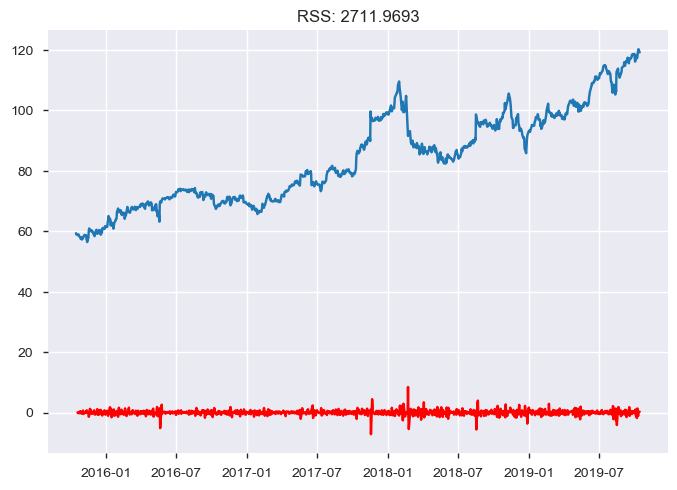

2 2 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


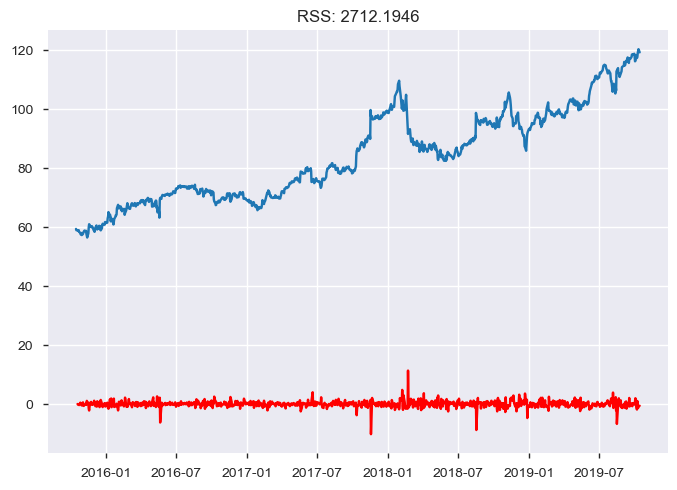

2 2 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


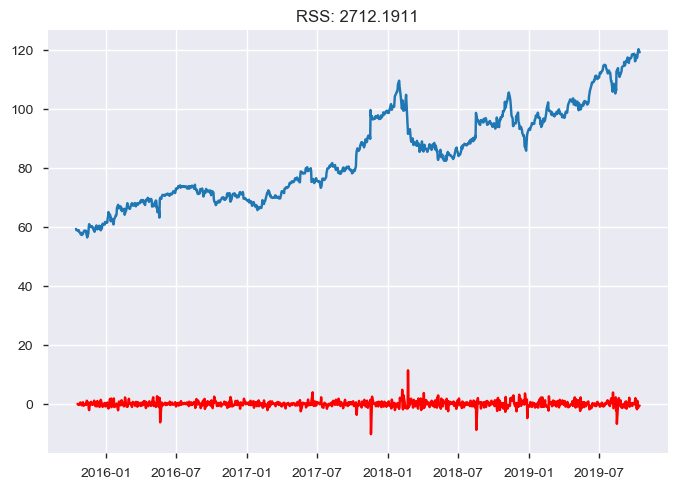

2 2 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


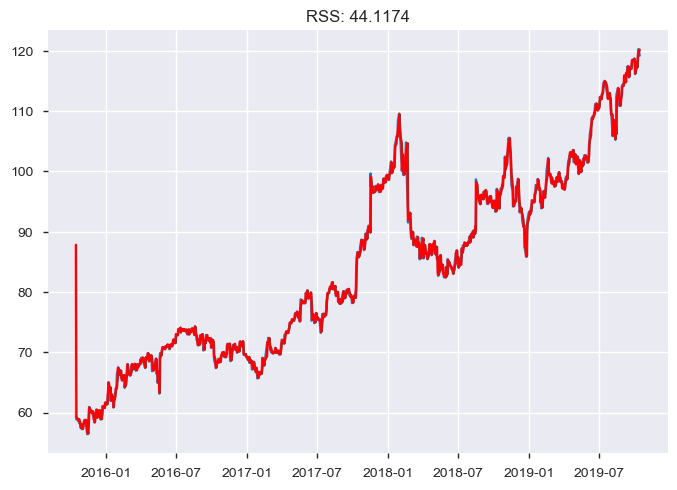

3 0 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


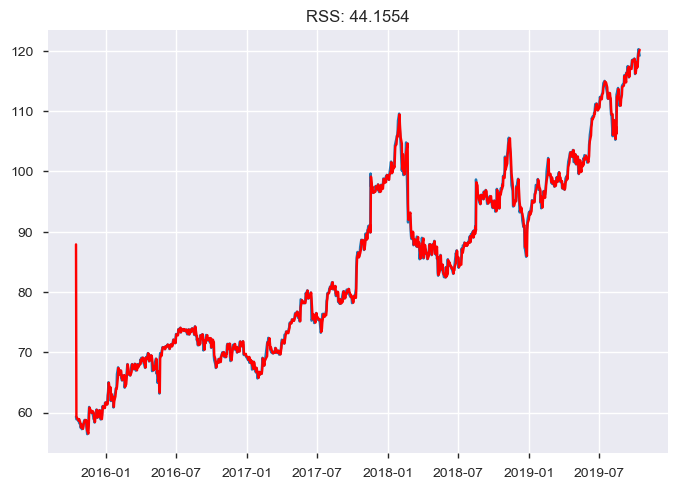

3 0 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


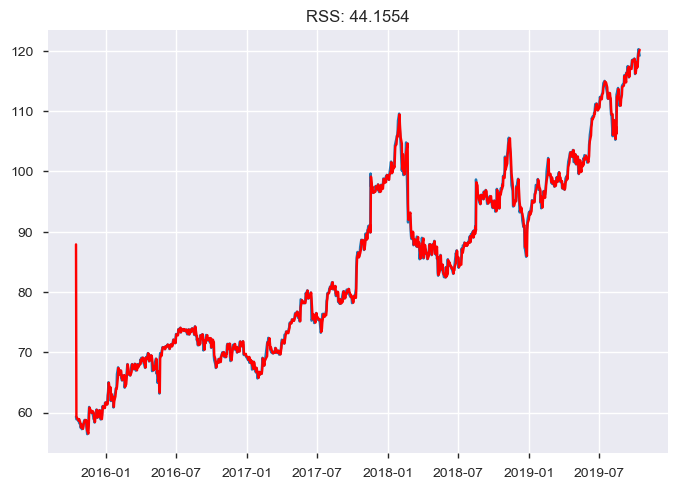

3 0 2


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


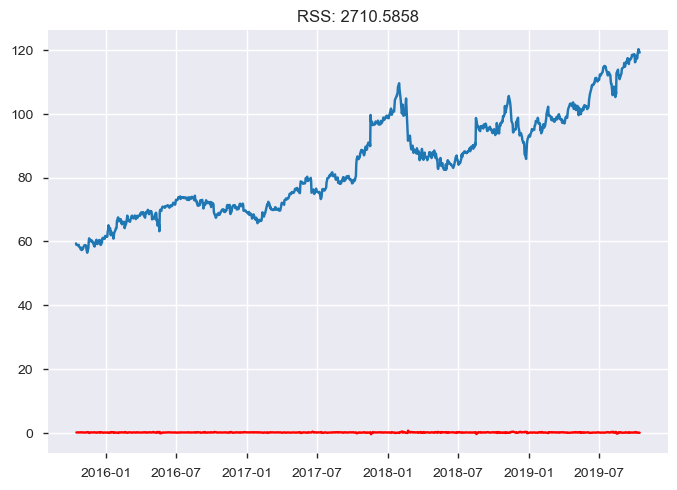

3 1 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


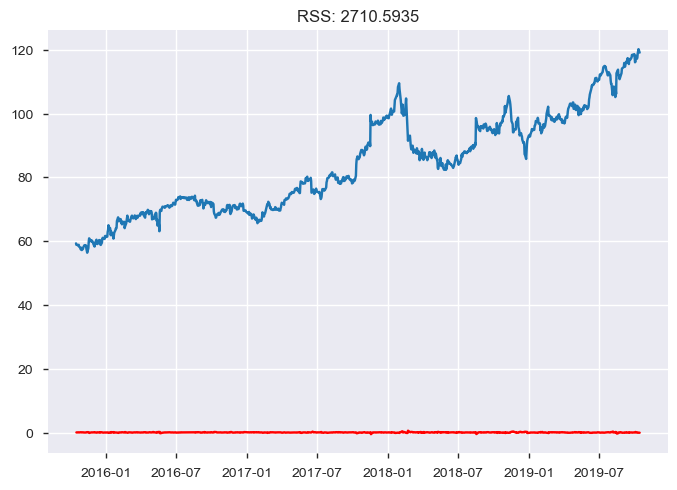

3 1 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


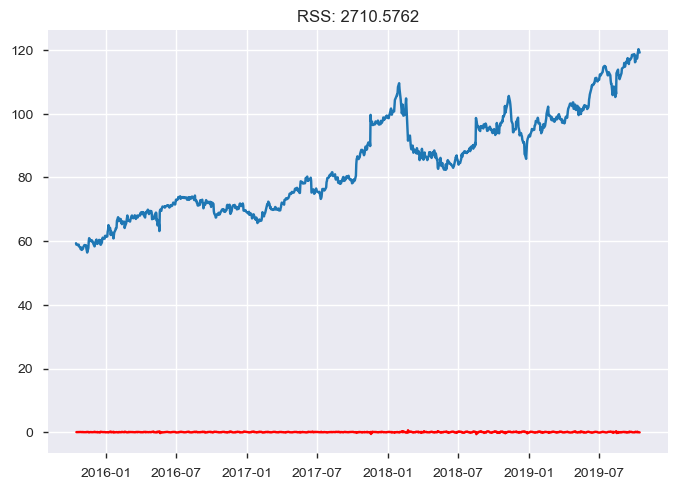

C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3 1 2


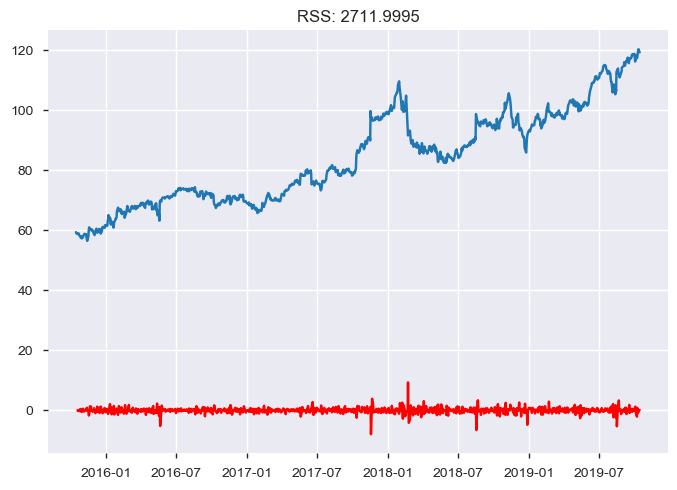

3 2 0


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


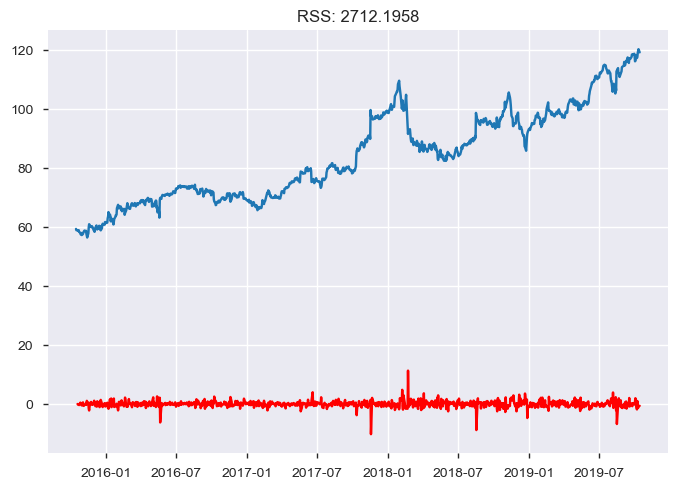

3 2 1


C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Brandon\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


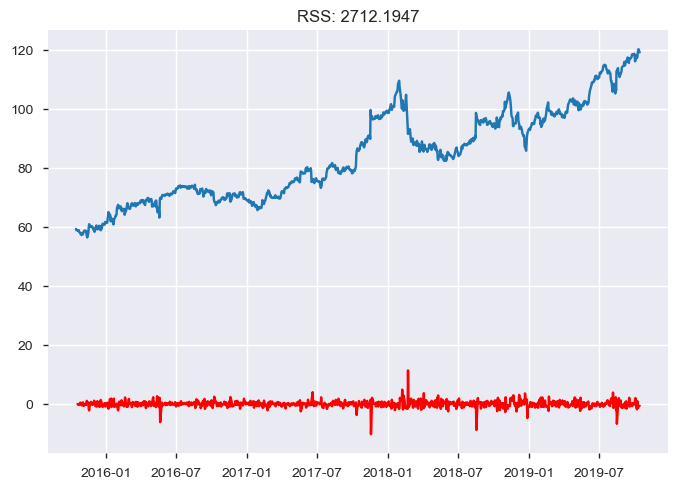

3 2 2


In [92]:
pdq_results = []

air_pop = wmt_stock.astype(float)
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(4):
    for d in range(3):
        for q in range(3):
            model = ARIMA(wmt_stock.dropna(), order=(p, d, q))  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            plt.plot(wmt_stock)
            plt.plot(results_ARIMA.fittedvalues, color='red')
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(wmt_stock)
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            plt.title('RSS: %.4f'% loss)
            pdq_results.append(f"p:{p} d:{d} q:{q} p+q:{p+q} rss:{loss} aic:{results_ARIMA.aic}")
            if loss < loss_best:
                print(loss)
                if (p > 1 and q <= 1) or (q > 1 and p <= 1) or (p <= 1 and q <= 1):
                    loss_best = loss
                    best_ints=[p,d,q]
            plt.show()
            print(p,d,q)

In [93]:
# print(pdq_results)
print(len(pdq_results))
for result in pdq_results:
    print(result)

36
p:0 d:0 q:0 p+q:0 rss:495.6810484363552 aic:8390.02109086035
p:0 d:0 q:1 p+q:1 rss:262.5911778094207 aic:7107.489763018333
p:0 d:0 q:2 p+q:2 rss:161.3891345458814 aic:6116.054954714246
p:0 d:1 q:0 p+q:0 rss:2710.553108694483 aic:2979.701766337944
p:0 d:1 q:1 p+q:1 rss:2710.5730841707227 aic:2978.2439175327604
p:0 d:1 q:2 p+q:2 rss:2710.583591613856 aic:2979.199228688518
p:0 d:2 q:0 p+q:0 rss:2711.789157889744 aic:3728.383304618825
p:0 d:2 q:1 p+q:1 rss:2712.1662076138464 aic:2986.372963446604
p:0 d:2 q:2 p+q:2 rss:2712.1662076138464 aic:2986.372963446604
p:1 d:0 q:0 p+q:1 rss:43.997115746183596 aic:2993.830094382915
p:1 d:0 q:1 p+q:2 rss:44.08400381996745 aic:2992.886870910899
p:1 d:0 q:2 p+q:3 rss:44.128019561141514 aic:2994.1278619044583
p:1 d:1 q:0 p+q:1 rss:2710.5707298743214 aic:2978.4657003139673
p:1 d:1 q:1 p+q:2 rss:2710.5933809113412 aic:2978.674653379036
p:1 d:1 q:2 p+q:3 rss:2710.5933809113412 aic:2978.674653379036
p:1 d:2 q:0 p+q:1 rss:2711.919326884731 aic:3424.47072409

In [94]:
print(loss_best)
print(best_ints)

43.997115746183596
[1, 0, 0]


In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for param in pdq:
   for param_seasonal in seasonal_pdq:
       try:
           mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
           results = mod.fit()
           print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
       except:
           continue